.ipynb settings

In [1]:
#Settings relative to .ipynb file format that have to be executed here

#Make reloading of modules automatic et évite d'avoir à redémarer le kernel et tout re executer pour appliquer la modification d'un module dans __main__.
%load_ext autoreload  
%autoreload 2

In [2]:
#src.useful_functions
import sys
sys.path.append('../src')  # Adjust the path to import modules in src/

import useful_functions

Importation of the dataset(s)

In [14]:
#Importing dataset(s)
from data import make_dataset

#Load the train and test datasets:
X_train_00   = make_dataset.load_data(False, 'processed/split/X_train_00')
Y_train_00   = make_dataset.load_data(False, 'processed/split/Y_train_00')
X_test_00 = make_dataset.load_data(False, 'processed/split/X_test_00')
Y_test_00 = make_dataset.load_data(False, 'processed/split/Y_test_00')


#Load the not_split train and test datasets:
X   = make_dataset.load_data(False, 'processed/not_split/X')
Y   = make_dataset.load_data(False, 'processed/not_split/Y')
X_info = make_dataset.load_data(False, 'processed/not_split/X_info')


# VI) <u> Pipeline development 

<span style="color:#FF1493;"> <strong> <font size="4">1) Pipeline and GridSearchCV implementation

In [40]:

# --------------------------------------------------------------
# Correlated features remover (not used)
# --------------------------------------------------------------

from features import features_selection
from configuration import constant_variables
from dvclive import Live


#Correlated features remover definition (it's a transformer)
corr_features_selector = features_selection.correlated_features_removal_transformer(corr_threshold = 0.95)


# --------------------------------------------------------------
# Features selector
# --------------------------------------------------------------

"""
from sklearn.linear_model import LogisticRegression
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

model_sfs = LogisticRegression(max_iter=10000, C = 0.3, random_state =33, penalty = 'l2')
sequ_feat_selector = SFS(estimator = model_sfs, k_features = 'best', forward = True, verbose = 0, cv=constant_variables.CV, scoring = 'neg_log_loss', n_jobs = -1)
"""

#OU

#Filter features selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
filter_feat_selector = SelectKBest(f_classif, k= 10)

# --------------------------------------------------------------
# Scaler
# --------------------------------------------------------------

from sklearn.preprocessing import RobustScaler, StandardScaler
scaler = StandardScaler()


# --------------------------------------------------------------
# Model
# --------------------------------------------------------------
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(penalty = 'l1', fit_intercept=True, random_state = 999, solver = 'saga', max_iter= 3000, verbose = False, tol=1e-4)

# --------------------------------------------------------------
# Pipeline
# --------------------------------------------------------------
from sklearn.pipeline import Pipeline
pipeline = Pipeline(steps=[("scaler",scaler), ("features_selector",filter_feat_selector), ("model", model)])


#parameters to optimize definition
import numpy as np
parameters = {'model__penalty': ['l1', 'l2', 'elasticnet', 'None'],
             'model__C': np.logspace(-3, 1, 21),
             'model__solver': ['saga', 'sag', 'liblinear', 'newton-cg', 'lbfgs'],
             'features_selector__k' : [6,11,13,16,17]
             }

# --------------------------------------------------------------
# GridSearchCV
# --------------------------------------------------------------
# Create a GridSearchCV object
from sklearn.model_selection import GridSearchCV
from configuration import constant_variables

grid_search = GridSearchCV(pipeline, parameters, cv=constant_variables.CV, scoring = 'neg_log_loss', verbose=0)
# Fit the GridSearchCV to the data
grid_search.fit(X_train_00.copy(), Y_train_00.copy().values.ravel())




c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
7560 fits failed out of a total of 10500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
420 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\base.py", line 1152, in wrapper
   

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('features_selector', SelectKBest()),
                                       ('model',
                                        LogisticRegression(max_iter=3000,
                                                           penalty='l1',
                                                           random_state=999,
                                                           solver='saga',
                                                           verbose=False))]),
             param_grid={'features_selector__k': [6, 11, 13, 16, 17],
                         'model__C': array([1.00000000e-03...
       6.30957344e-03, 1.00000000e-02, 1.58489319e-02, 2.51188643e-02,
       3.98107171e-02, 6.30957344e-02, 1.00000000e-01, 1.58489319e-01,
       2.51188643e-01, 3.98107171e-01, 6.30957344e-01, 1.00000000e+00,
       1.58489319e+00, 2.51188643e+00, 3.98107171e+00, 6.30957344e+00,
       1.00000000e+01]),
                         'model__penalty': ['l1', 'l2', 'elasticnet', 'None'],
                         'model__solver': ['saga', 'sag', 'liblinear',
                                           'newton-cg', 'lbfgs']},
             scoring='neg_log_loss')

<span style="color:#808080;"> <strong> <font size="4">2) Model calibration (Not used for Logistic Reg)

In [5]:

#definition of a calibrator
"""
from sklearn.calibration import CalibratedClassifierCV
calibrated_pipeline = CalibratedClassifierCV(chosen_pipeline_trained, cv = 'prefit' , method = 'isotonic', ensemble = True)
calibrated_pipeline.fit(X_valid_00.copy(), Y_valid_00.copy())
"""


"\nfrom sklearn.calibration import CalibratedClassifierCV\ncalibrated_pipeline = CalibratedClassifierCV(chosen_pipeline_trained, cv = 'prefit' , method = 'isotonic', ensemble = True)\ncalibrated_pipeline.fit(X_valid_00.copy(), Y_valid_00.copy())\n"

In [59]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import warnings

# Supprimer les avertissements inutiles
warnings.filterwarnings("ignore", category=UserWarning)

# Calcul de la matrice de corrélation
correlation_matrix = X_train_00.corr()

# Calcul de la corrélation moyenne par variable
correlation_values = correlation_matrix.values
np.fill_diagonal(correlation_values, np.nan)  # Ignore les diagonales
global_mean_correlation = np.nanmean(np.abs(correlation_values))
mean_correlation_per_variable = np.nanmean(np.abs(correlation_values), axis=1)

print(f"\nGlobal Mean Correlation (excluding diagonals): {global_mean_correlation:.4f}\n")

# Calcul de la corrélation entre chaque variable et la target (Y)
print("\nCorrelation of each variable with the target (Y):")
Y_train_flat = np.ravel(Y_train_00)  # Aplatir Y_train pour éviter les erreurs de dimensions
correlations_with_target = []
for column in X_train_00.columns:
    correlation = np.corrcoef(X_train_00[column], Y_train_flat)[0, 1]
    correlations_with_target.append(correlation)
    print(f"{column:<40} {correlation:.4f}")

# Initialisation des listes pour stocker les résultats
precisions = []
recalls = []

# Initialisation des scores de base
prev_precision = 0
prev_recall = 0

# Nombre total de colonnes
n_cols = X_train_00.shape[1]

# En-tête pour le tableau
print(f"\n{'Variable':<40} {'Mean Correlation':<20} {'Precision Improvement':<25} {'Recall Improvement':<25}")
print("-" * 110)

# Boucle pour entraîner et évaluer le modèle avec un nombre croissant de colonnes
for i in range(1, n_cols + 1):
    # Sélection des i premières colonnes
    X_train_subset = X_train_00.iloc[:, :i].to_numpy()
    X_test_subset = X_test_00.iloc[:, :i].to_numpy()

    # Création et entraînement de la pipeline
    model_test = LogisticRegression(
        penalty='l2', fit_intercept=True, random_state=999,
        C=0.63, solver='sag', max_iter=3000, verbose=False, tol=1e-4
    )
    pipeline_test = Pipeline(steps=[("scaler", StandardScaler()), ("model", model_test)])
    pipeline_test.fit(X_train_subset, Y_train_00)

    # Prédiction des classes pour les données de test
    predicted_classes = pipeline_test.predict(X_test_subset)

    # Calcul de la précision et du recall
    Y_test_00_copy = np.array(Y_test_00).astype(int)  # Conversion en tableau NumPy d'entiers
    precision = precision_score(Y_test_00_copy, predicted_classes)
    recall = recall_score(Y_test_00_copy, predicted_classes)

    # Calcul des améliorations
    precision_improvement = precision - prev_precision
    recall_improvement = recall - prev_recall

    # Stockage des métriques
    precisions.append(precision)
    recalls.append(recall)

    # Mise à jour des scores précédents
    prev_precision = precision
    prev_recall = recall

    # Affichage des résultats pour chaque variable ajoutée
    mean_corr = mean_correlation_per_variable[i - 1]  # Corrélation moyenne de la variable actuelle
    print(f"{correlation_matrix.columns[i - 1]:<40} {mean_corr:<20.4f} {precision_improvement:<25.4f} {recall_improvement:<25.4f}")

# Résumé des métriques finales
print("\nSummary of Results:")
for i, (prec, rec) in enumerate(zip(precisions, recalls), start=1):
    print(f"Columns used: {i}, Precision: {prec:.4f}, Recall: {rec:.4f}")




Global Mean Correlation (excluding diagonals): 0.4066


Correlation of each variable with the target (Y):
Diff_Avg_points_pm_ponderated_by_adversary_perf 0.2703
Diff_Avg_goal_diff                       0.2838
Diff_Avg_scored_g_conceeded_g_ratio      0.2648
Diff_Avg_collected_points                0.2682
Diff_Annual_budget                       0.2744
Diff_Points_5lm                          0.1892
Diff_Goal_Diff_5lm                       0.2838
Diff_Week_ranking_5lm                    0.0752
Diff_avg_corners_nb                      0.1655
Diff_Avg_shots_nb                        0.2314
Diff_Avg_shots_on_target_nb              0.2648
Diff_Avg_fouls_nb                        -0.0903
Diff_Avg_possession                      0.2708
Diff_Avg_xg                              0.2595
H_A_status                               0.1824
Season_year                              -0.0080

Variable                                 Mean Correlation     Precision Improvement     Recall Improvement       
-

### Arbres de decision

In [45]:
from sklearn.metrics import precision_score, recall_score
import numpy as np

# Génération de 3 colonnes aléatoires pour les features
np.random.seed(999)  # Pour des résultats reproductibles
X_train_random = np.random.rand(X_train_00.shape[0], 3)
X_test_random = np.random.rand(X_test_00.shape[0], 3)

# Création et entraînement du modèle avec les colonnes aléatoires
model_test_random = LogisticRegression(
    penalty='l2', fit_intercept=True, random_state=999,
    C=0.63, solver='sag', max_iter=3000, verbose=False, tol=1e-4
)
pipeline_test_random = Pipeline(steps=[("scaler", scaler), ("model", model_test_random)])
pipeline_test_random.fit(X_train_random, Y_train_00)

# Prédiction des classes pour les données de test
predicted_classes_random = pipeline_test_random.predict(X_test_random)

# Calcul de la précision et du recall
precision_random = precision_score(Y_test_00_copy, predicted_classes_random)
recall_random = recall_score(Y_test_00_copy, predicted_classes_random)

# Affichage des résultats
print(f"Random features - Precision: {precision_random:.4f}")
print(f"Random features - Recall: {recall_random:.4f}")


c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Random features - Precision: 0.0000
Random features - Recall: 0.0000


test avec autre dataset

In [74]:

XX   = make_dataset.load_data(False, 'interim/feat_engineered_ds')

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import warnings

# Supprimer les avertissements
warnings.filterwarnings("ignore", category=UserWarning)

# === 1) Construction des data X & y (exemple, ajustez selon vos colonnes) ===
X = pd.DataFrame({
    "diff_ppg": XX["Pre-Match PPG (Home)"] - XX["Pre-Match PPG (Away)"],
    "diff_xG": XX["Home Team Pre-Match xG"] - XX["Away Team Pre-Match xG"],
    "over_15_HT_FHG": XX["over_15_HT_FHG_percentage_pre_match"],
    "over_05_HT_FHG": XX["over_05_HT_FHG_percentage_pre_match"],
    "diff_victories": XX["HT_victories_nb"] - XX["AT_victories_nb"]
})
y = XX["RH"]

# === 2) Séparation train/test ===
X_train_00, X_test_00, Y_train_00, Y_test_00 = train_test_split(
    X, y, test_size=0.2, random_state=999
)

# === 3) Imputation simple des NaN par la moyenne ===
X_train_00 = X_train_00.fillna(X_train_00.mean())
X_test_00  = X_test_00.fillna(X_test_00.mean())

# === 4) Votre code d'entraînement et d'évaluation ===
correlation_matrix = X_train_00.corr()
correlation_values = correlation_matrix.values
np.fill_diagonal(correlation_values, np.nan)
global_mean_correlation = np.nanmean(np.abs(correlation_values))
mean_correlation_per_variable = np.nanmean(np.abs(correlation_values), axis=1)

print(f"\nGlobal Mean Correlation (excluding diagonals): {global_mean_correlation:.4f}\n")

print("\nCorrelation of each variable with the target (Y):")
Y_train_flat = np.ravel(Y_train_00)
for column in X_train_00.columns:
    corr = np.corrcoef(X_train_00[column], Y_train_flat)[0, 1]
    print(f"{column:<40} {corr:.4f}")

precisions = []
recalls = []
prev_precision = 0
prev_recall = 0

n_cols = X_train_00.shape[1]

print(f"\n{'Variable':<40} {'Mean Correlation':<20} {'Precision Improvement':<25} {'Recall Improvement':<25}")
print("-" * 110)

for i in range(1, n_cols + 1):
    X_train_subset = X_train_00.iloc[:, :i].to_numpy()
    X_test_subset = X_test_00.iloc[:, :i].to_numpy()

    model_test = LogisticRegression(
        penalty='l2', fit_intercept=True, random_state=999,
        C=0.63, solver='sag', max_iter=3000, verbose=False, tol=1e-4
    )
    pipeline_test = Pipeline([("scaler", StandardScaler()), ("model", model_test)])
    pipeline_test.fit(X_train_subset, Y_train_00)

    predicted_classes = pipeline_test.predict(X_test_subset)

    Y_test_00_copy = np.array(Y_test_00).astype(int)
    precision = precision_score(Y_test_00_copy, predicted_classes)
    recall = recall_score(Y_test_00_copy, predicted_classes)

    precision_improvement = precision - prev_precision
    recall_improvement = recall - prev_recall

    precisions.append(precision)
    recalls.append(recall)
    prev_precision = precision
    prev_recall = recall

    mean_corr = mean_correlation_per_variable[i - 1]
    col_name = correlation_matrix.columns[i - 1]
    print(f"{col_name:<40} {mean_corr:<20.4f} {precision_improvement:<25.4f} {recall_improvement:<25.4f}")

print("\nSummary of Results:")
for i, (prec, rec) in enumerate(zip(precisions, recalls), start=1):
    print(f"Columns used: {i}, Precision: {prec:.4f}, Recall: {rec:.4f}")




Global Mean Correlation (excluding diagonals): 0.2027


Correlation of each variable with the target (Y):
diff_ppg                                 0.2009
diff_xG                                  0.0713
over_15_HT_FHG                           0.0126
over_05_HT_FHG                           0.0302
diff_victories                           0.2754

Variable                                 Mean Correlation     Precision Improvement     Recall Improvement       
--------------------------------------------------------------------------------------------------------------
diff_ppg                                 0.2430               0.4921                    0.2925                   
diff_xG                                  0.1300               0.0188                    0.0031                   
over_15_HT_FHG                           0.2055               0.0001                    -0.0031                  
over_05_HT_FHG                           0.2156               -0.0137                

<span style="color:#FF1493;"> <strong> <font size="4">3) Display GridSearchCV results

Pipeline(steps=[('scaler', StandardScaler()),
                ('features_selector', SelectKBest(k=13)),
                ('model',
                 LogisticRegression(C=0.025118864315095808, max_iter=3000,
                                    random_state=999, solver='newton-cg',
                                    verbose=False))])
Best Parameters: {'features_selector__k': 13, 'model__C': 0.025118864315095808, 'model__penalty': 'l2', 'model__solver': 'newton-cg'}

Best score with these hyperparameters: -0.5875402732891138

Selected Features: ['Diff_Avg_points_pm_ponderated_by_adversary_perf', 'Diff_Avg_goal_diff', 'Diff_Avg_scored_g_conceeded_g_ratio', 'Diff_Avg_collected_points', 'Diff_Annual_budget', 'Diff_Points_5lm', 'Diff_Goal_Diff_5lm', 'Diff_avg_corners_nb', 'Diff_Avg_shots_nb', 'Diff_Avg_shots_on_target_nb', 'Diff_Avg_possession', 'Diff_Avg_xg', 'H_A_status']


c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\notebooks\../src\pipeline\results.py:496: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  X_info_pred = pd.concat([X_info_pred, X_test_info_for_this_seas], ignore_index=True, axis=0)


Successfully loaded the datasets: pipeline_pred_proba_and_Y_and_X_info


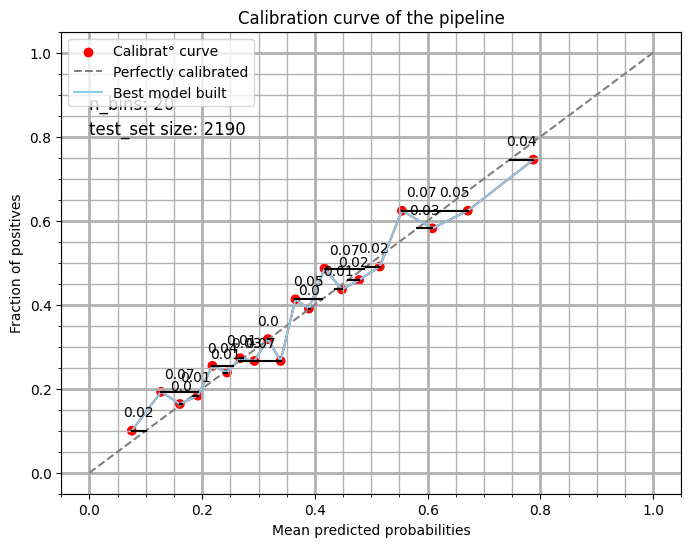

Above learning curve statistics on bins:

╒════╤════════════════╤═════════════════════════════╕
│    │ Bin interval   │   Predictions nb in the bin │
╞════╪════════════════╪═════════════════════════════╡
│  0 │ [0.02, 0.11]   │                         110 │
├────┼────────────────┼─────────────────────────────┤
│  1 │ [0.11, 0.15]   │                         109 │
├────┼────────────────┼─────────────────────────────┤
│  2 │ [0.15, 0.18]   │                         110 │
├────┼────────────────┼─────────────────────────────┤
│  3 │ [0.18, 0.21]   │                         109 │
├────┼────────────────┼─────────────────────────────┤
│  4 │ [0.21, 0.23]   │                         110 │
├────┼────────────────┼─────────────────────────────┤
│  5 │ [0.23, 0.25]   │                         109 │
├────┼────────────────┼─────────────────────────────┤
│  6 │ [0.25, 0.28]   │                         110 │
├────┼────────────────┼─────────────────────────────┤
│  7 │ [0.28, 0.3]    │                 

In [41]:
#src.pipeline.results

from sklearn.base import clone

from pipeline import results

# On récupère la pipeline avec ses parametres optimaux 
chosen_pipeline = grid_search.best_estimator_

# We print the results of GridSearchCV() execution
print(chosen_pipeline)
results.GridSearchCV_results(grid_search, X_train_00.copy())


# Plot Calibration curve for the pipeline build by GridSearchCV
test_seasons = [2021,2022,2023,2024]

# Make proba predictions retraining the pipeline at every Game Week or every Season on test_seasons:
proba_predicted_GW_training, Y_test_GW_training, X_info_test_GW_training = results.proba_prediction_retrained_each_seas(X, Y, X_info, clone(chosen_pipeline), 'season', test_seasons)

#Plot Calibration curve of the pipeline and info about its bins
prob_pred_01, prob_true_01 = results.plot_calibration_curve_2(
                                Y_test_0 = Y_test_GW_training.copy(),
                                X_train_0 = X_info_test_GW_training.copy(),
                                proba_pred_0 = proba_predicted_GW_training.copy(),
                                n_bins_0 = 20,
                                strategy_0 = 'quantile',
                                color_0 = 'red',
                                GW_training_or_not = True,
                                )

#We display statistics on the pipeline probabilities deviation 
results.print_calibration_stats(prob_pred_01.copy(),
                                prob_true_01.copy(),
                                'non calibrated')


<span style="color:#FF1493;"> <strong> <font size="4">4) Pipeline and dataframes Saving


In [11]:
#src.pipeline.model
from pipeline import model
from features.features_selection import restricted_datasets



#On récupère la pipeline avec ses parametres optimaux 
chosen_pipeline = grid_search.best_estimator_

chosen_pipeline_trained = chosen_pipeline.fit(X_train_00.copy(), Y_train_00.copy().values.ravel())




In [12]:
#src.pipeline.model #src.data.make_dataset
#Save the trained pipeline

model.save_pipeline(chosen_pipeline, "chosen_pipeline_trained")
model.save_pipeline(chosen_pipeline, "chosen_pipeline")

#Saving dataset(s)
from data import make_dataset




Successfully deleted the old pipeline:     chosen_pipeline_trained
Successfully saved the new pipeline:       chosen_pipeline_trained


Successfully deleted the old pipeline:     chosen_pipeline
Successfully saved the new pipeline:       chosen_pipeline


